**Laboratorio N°7 - SIS420**

**Introducción.**

Este laboratorio en parejas se enfocará en el estudio de los diferentes métodos o estrategias para entrenar un modelo de aprendizaje por refuerzo, esto estudiando métodos como: Implementación incremental, valores iniciales optimistas, selección de acciones con intervalo de confianza, implementación incremental y ascenso por el gradiente, donde para cada uno de estos métodos se tendrán gráficas para medir el rendimiento y compararlas.

**Objetivos.**

- Comprender la diferencia entre Exploración y Explotación.
- Aplicar las estrategias a un determinado juego de la librería gymnasium.
- Comparar las estrategias en términos de eficiencia y efectividad para encontrar la mejor acción.
- Visualizar Resultados.

# **Instalación de Librerías para Trabajar con los entornos.**

Es necesario instalar las librerías para poder trabajar con gymnasium y sus respectivos juegos o elementos

In [46]:
!pip install --upgrade pip setuptools wheel
!sudo apt-get install build-essential python3-dev swig
!pip install gymnasium
!pip install gym
!pip install Ale
!pip install ale-py
!pip install gym[atari]
!pip install AutoROM
!pip install nes_py
!pip install pypybox2d
!pip install AutoROM.accept-rom-license
!pip install gym_chess
!pip install gymnasium[box2d]
!pip install gymnasium[mujoco]
!pip install jax

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
swig is already the newest version (4.0.2-1ubuntu1).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


# **Preparación de clases y librerías.**

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gym.envs import registry
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Entornos disponibles.** Se muestran los entornos disponibles, de los cuales se seleccionará FrozenLake8x8 por facilidad de implementación.

In [48]:
entornos = gym.envs.registry.values()
entornos_lista = sorted([env_spec.id for env_spec in entornos])
for ent in entornos_lista:
    print(ent)

Acrobot-v1
Ant-v2
Ant-v3
Ant-v4
BipedalWalker-v3
BipedalWalkerHardcore-v3
Blackjack-v1
CarRacing-v2
CartPole-v0
CartPole-v1
CliffWalking-v0
FrozenLake-v1
FrozenLake8x8-v1
GymV21Environment-v0
GymV26Environment-v0
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
InvertedPendulum-v2
InvertedPendulum-v4
LunarLander-v2
LunarLanderContinuous-v2
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Pusher-v2
Pusher-v4
Reacher-v2
Reacher-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Taxi-v3
Walker2d-v2
Walker2d-v3
Walker2d-v4
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
tabular/Blackjack-v0
tabular/CliffWalking-v0


**Creación de la clase ModeloQLearning.**
Dicha clase heredará ciertos atributos que son comunes entre los modelos, así se tendrá un código más generalizado.

*Fórmula General de actualización Qlearning*

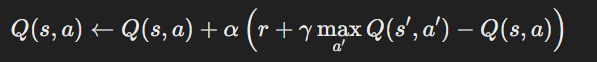

In [49]:
class ModeloQLearning:
    def __init__(self, _entorno):
        self.entorno = gym.make(_entorno)
        self.q_tabla = np.zeros([self.entorno.observation_space.n, self.entorno.action_space.n])
        self.contadores_accion = np.zeros([self.entorno.observation_space.n, self.entorno.action_space.n])
        self.rango = np.random.default_rng()

    def crearArchivoQTabla(self, _nombreArchivo):
        self.nombre_archivo = _nombreArchivo
        self.q_tabla = np.zeros([self.entorno.observation_space.n, self.entorno.action_space.n])
        np.savetxt(_nombreArchivo, self.q_tabla, delimiter=",")

    def cargarArchivoQTabla(self, _nombreArchivo):
        self.q_tabla = np.loadtxt(_nombreArchivo, delimiter=",")

    def modificarQTabla(self, _nombreArchivo):
        np.savetxt(_nombreArchivo, self.q_tabla, delimiter=",")

    def obtenerQTabla(self):
        self.q_tabla = np.loadtxt(self.nombre_archivo, delimiter=",")
        return self.q_tabla

    def elegirAccion(self, _estado, _epsilon):
        if self.rango.random() < _epsilon:
            return self.entorno.action_space.sample()
        else:
            return np.argmax(self.q_tabla[_estado, :])

    def graficarResultados(self, recompensas, iteraciones, epsilon):
        recompensa_media = np.cumsum(recompensas) / (np.arange(iteraciones) + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recompensas, label=f'ε = {epsilon}')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(recompensa_media, label=f'ε = {epsilon}')
        plt.xlabel('Experiencias')
        plt.ylabel('Ratio acción óptima')
        plt.legend()
        plt.grid(True)

        plt.show()

# ***Acción Valor.***

El modelo *acción valor* es un algoritmo de aprendizaje por refuerzo que utiliza una tabla Q (q_tabla) para almacenar los valores estimados de las acciones en diferentes estados. El objetivo es aprender la política óptima que maximiza la recompensa acumulada.

Inicializa una tabla Q con valores cero.
Durante cada episodio, el agente elige acciones basadas en una política ε-greedy (con probabilidad ε de explorar acciones aleatorias y con probabilidad 1-ε de explotar las mejores acciones conocidas).

**Hiperparámetros**
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.


In [50]:
class ModeloAV(ModeloQLearning):
    def __init__(self, _entorno):
        super().__init__(_entorno)

    def entrenar(self, _episodios, _ratio_aprendizaje, _probabilidad_exploracion, _decaimiento_epsilon, _factorDescuento, _ciclo_muestra = 100):
        print("Modelo de Acción Valor.\n")
        self.alpha = _ratio_aprendizaje
        self.gamma = _decaimiento_epsilon
        self.epsilon = _probabilidad_exploracion
        epsilon = self.epsilon
        self.lambda_ = _factorDescuento
        self.episodios = _episodios
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_accion_valor.txt'
        self.crearArchivoQTabla(nombre_q_tabla)
        for e in range(self.episodios):
            if (e + 1) % _ciclo_muestra == 0:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id, render_mode="human")
            else:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id)
            self.terminado = False
            self.detenido = False
            estado = self.entorno.reset()[0]
            while (not self.terminado and not self.detenido):
                accion = self.elegirAccion(estado, self.epsilon)
                nuevo_estado, recompensa, self.terminado, self.detenido, _ = self.entorno.step(accion)
                self.recompensas[e] += recompensa
               # Actualización incremental basada en la fórmula de Q-Learning
                self.q_tabla[estado, accion] += self.alpha * (recompensa + self.lambda_ * np.max(self.q_tabla[nuevo_estado, :]) - self.q_tabla[estado, accion])

                estado = nuevo_estado
                self.modificarQTabla(nombre_q_tabla)
            self.epsilon = max(self.epsilon - self.gamma, 0.01)
            if recompensa == 1:
                self.recompensas[e] = 1
        self.entorno.close()
        self.graficarResultados(self.recompensas, self.episodios, epsilon)

Modelo de Acción Valor.



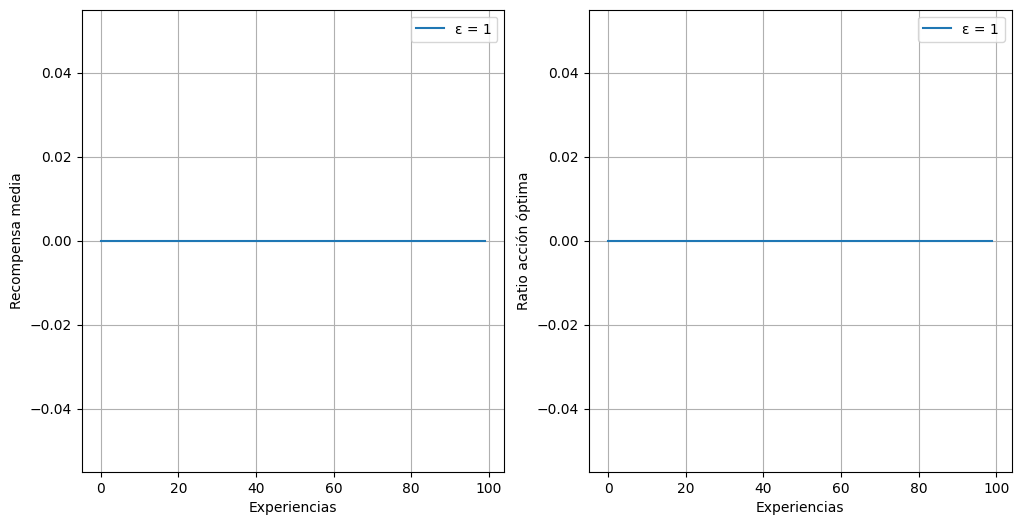

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [51]:
model_accion_valor = ModeloAV('FrozenLake8x8-v1')
# Parámetros de la función entrenar: (episodios, ratio de aprendizaje, probabilidad de exploración, decaimiento epsilon, factor de descuento)
model_accion_valor.entrenar(100, 0.1, 1, 0.01, 0.9, 10)
print(model_accion_valor.obtenerQTabla())

# ***Valores Iniciales Optimistas.***

Este modelo inicializa la tabla q con valores altos (optimistas). Esto fomenta la exploración, ya que al principio, todas las acciones parecen tener un alto valor potencial.

Inicializa la tabla Q con valores altos en lugar de ceros.

Sigue el mismo procedimiento de actualización de Q-Learning.

Utiliza la misma política ε-greedy para elegir acciones.

**Hiperparámetros**

- Valor Inicial: Valor con el que se inicializan las entradas de la tabla Q.
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.

In [52]:
class ModeloVIO(ModeloQLearning):
    def __init__(self, _entorno, valor_inicial):
        super().__init__(_entorno)
        self.q_tabla = np.full([self.entorno.observation_space.n, self.entorno.action_space.n], valor_inicial)

    def entrenar(self, _episodios, _ratio_aprendizaje, _probabilidad_exploracion, _decaimiento_epsilon, _factorDescuento, _ciclo_muestra = 100):
        print("Modelo de Valores Iniciales Optimistas.\n")
        self.alpha = _ratio_aprendizaje
        self.gamma = _decaimiento_epsilon
        self.epsilon = _probabilidad_exploracion
        epsilon = self.epsilon
        self.lambda_ = _factorDescuento
        self.episodios = _episodios
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_valores_iniciales_optimistas.txt'
        self.crearArchivoQTabla(nombre_q_tabla)

        for e in range(self.episodios):
            if (e + 1) % _ciclo_muestra == 0:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id, render_mode="human")
            else:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id)

            self.terminado = False
            self.detenido = False
            estado = self.entorno.reset()[0]
            while (not self.terminado and not self.detenido):
                accion = self.elegirAccion(estado, self.epsilon)
                nuevo_estado, recompensa, self.terminado, self.detenido, _ = self.entorno.step(accion)
                self.recompensas[e] += recompensa

                # Actualización incremental basada en la fórmula de Q-Learning
                self.q_tabla[estado, accion] += self.alpha * (recompensa + self.lambda_ * np.max(self.q_tabla[nuevo_estado, :]) - self.q_tabla[estado, accion])

                estado = nuevo_estado
                self.modificarQTabla(nombre_q_tabla)
            self.epsilon = max(self.epsilon - self.gamma, 0.01)
            if recompensa == 1:
                self.recompensas[e] = 1
        self.entorno.close()
        self.graficarResultados(self.recompensas, self.episodios, epsilon)


Modelo de Valores Iniciales Optimistas.



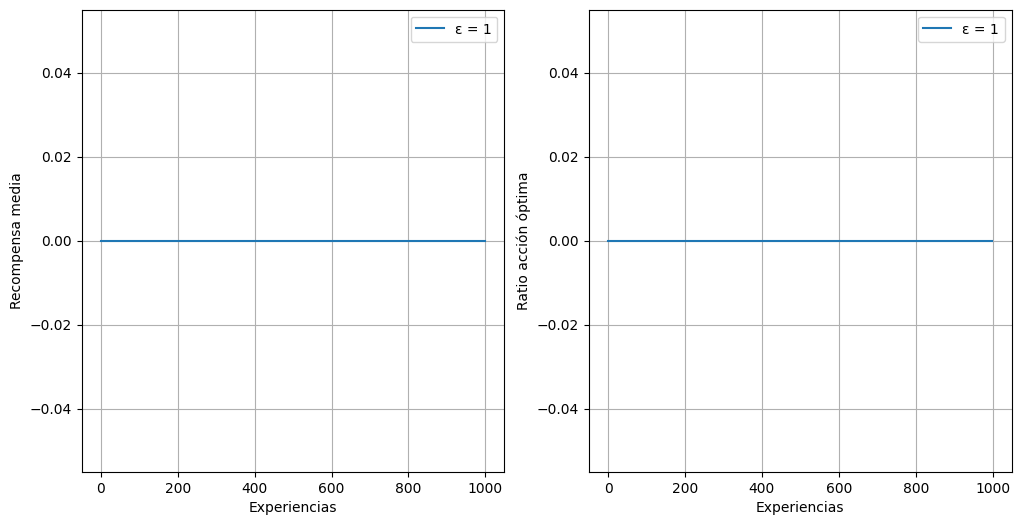

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [53]:
# Parámetro agregado: Valor Inicial
model_valores_iniciales_optimistas = ModeloVIO('FrozenLake-v1', 1000)
# Parámetros de la función entrenar: (episodios, ratio de aprendizaje, probabilidad de exploración, decaimiento epsilon, factor de descuento)
model_valores_iniciales_optimistas.entrenar(1000, 0.1, 1, 0.01, 0.9, 10)
print(model_valores_iniciales_optimistas.obtenerQTabla())

# ***Selección de Acciones con Intérvalo de Confianza.***

Este modelo implementa una estrategia de selección de acciones basada en intervalos de confianza, donde se eligen acciones no solo por su valor esperado, sino también considerando la incertidumbre en las estimaciones.

Inicializa una tabla Q y un contador de acciones.
Durante cada episodio, el agente selecciona acciones basándose en una combinación del valor estimado y un término de exploración que decrece con el número de veces que se ha elegido la acción.
Actualiza la tabla Q y el contador de acciones después de cada interacción con el entorno.

**Hiperparámetros**

- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.

In [54]:
class ModeloAIC(ModeloQLearning):
    def __init__(self, _entorno):
        super().__init__(_entorno)
        self.tiempo = 0

    def elegirAccion(self, _estado, _confianza):
        self.tiempo += 1
        total_acciones = np.sum(self.contadores_accion[_estado, :]) + 1
        valores_ucb = self.q_tabla[_estado, :] + _confianza * np.sqrt(np.log(total_acciones) / (self.contadores_accion[_estado, :] + 1))
        return np.argmax(valores_ucb)

    def graficarResultados(self, recompensas, iteraciones, c):
        recompensa_media = np.cumsum(recompensas) / (np.arange(iteraciones) + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recompensas, label=f'UCB c = {c}')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(recompensa_media, label=f'UCB c = {c}')
        plt.xlabel('Experiencias')
        plt.ylabel('Ratio acción óptima')
        plt.legend()
        plt.grid(True)

        plt.show()

    def entrenar(self, _episodios, _ratio_aprendizaje, _confianza, _factorDescuento, _ciclo_muestra = 100):
        print("Modelo de Acciones con Intérvalo de Confianza")
        self.alpha = _ratio_aprendizaje
        self.lambda_ = _factorDescuento
        self.episodios = _episodios
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_ucb.txt'
        self.crearArchivoQTabla(nombre_q_tabla)

        for e in range(self.episodios):
            if (e + 1) % _ciclo_muestra == 0:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id, render_mode="human")
            else:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id)

            self.terminado = False
            self.detenido = False
            estado = self.entorno.reset()[0]
            while (not self.terminado and not self.detenido):
                accion = self.elegirAccion(estado, _confianza)
                nuevo_estado, recompensa, self.terminado, self.detenido, _ = self.entorno.step(accion)
                self.recompensas[e] += recompensa
                # Actualización incremental basada en la fórmula de Q-Learning
                self.q_tabla[estado, accion] += self.alpha * (recompensa + self.lambda_ * np.max(self.q_tabla[nuevo_estado, :]) - self.q_tabla[estado, accion])
                self.contadores_accion[estado, accion] += 1

                estado = nuevo_estado
                self.modificarQTabla(nombre_q_tabla)
        self.entorno.close()
        self.graficarResultados(self.recompensas, self.episodios, _confianza)

Modelo de Acciones con Intérvalo de Confianza


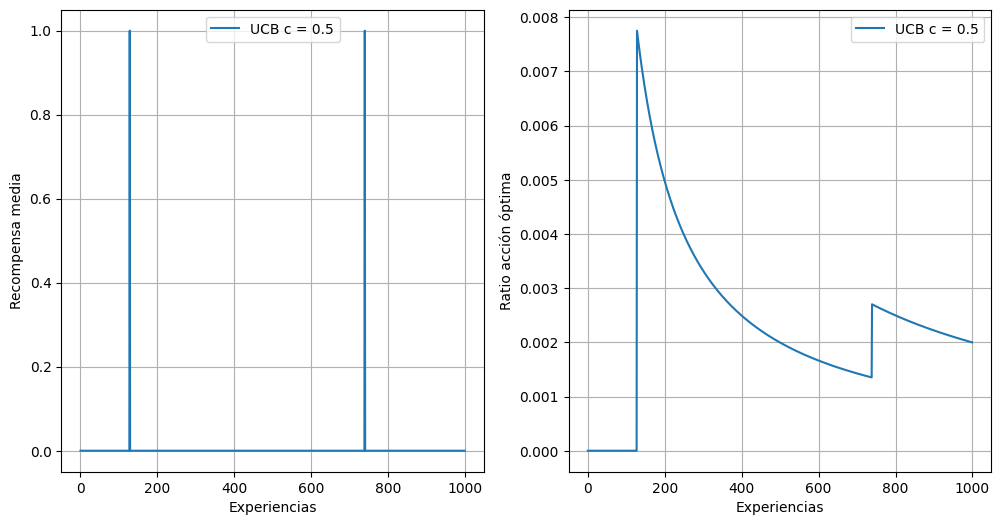

[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.

In [55]:
model_ucb = ModeloAIC('FrozenLake8x8-v1')
# Parámetros de la función entrenar: (episodios, ratio de aprendizaje, ratio de confianza, factor de descuento)
model_ucb.entrenar(1000, 0.1, 0.5, 0.9, 10)
print(model_ucb.obtenerQTabla())

# ***Algoritmos de Gradiente***

El modelo de Ascenso por el Gradiente utiliza el método de gradiente de política para actualizar directamente las preferencias de las acciones en lugar de estimar los valores Q.

Inicializa un vector de preferencias para cada acción.
Calcula las probabilidades de seleccionar cada acción usando la función softmax sobre las preferencias.
Elige acciones basadas en estas probabilidades.

**Hiperparámetros**
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina la magnitud de los ajustes a las preferencias.
- Promedio de Recompensas: Promedio incremental de las recompensas recibidas hasta el momento.


In [56]:
class ModeloAscensoGradiente:
    def __init__(self, _entorno, num_acciones):
        self.entorno = gym.make(_entorno)
        self.num_acciones = num_acciones
        self.preferencias = np.zeros(num_acciones)
        self.probabilidades = np.zeros(num_acciones)
        self.promedio_recompensas = 0
        self.recompensas = []
        self.tiempo = 0
        self.rango = np.random.default_rng()

    def softmax(self):
        exp_h = np.exp(self.preferencias - np.max(self.preferencias))
        self.probabilidades = exp_h / np.sum(exp_h)

    def elegirAccion(self):
        self.softmax()
        return self.rango.choice(self.num_acciones, p=self.probabilidades)

    def actualizarPreferencias(self, accion, recompensa, alpha):
        self.tiempo += 1
        self.promedio_recompensas += (recompensa - self.promedio_recompensas) / self.tiempo
        for a in range(self.num_acciones):
            if a == accion:
                self.preferencias[a] += alpha * (recompensa - self.promedio_recompensas) * (1 - self.probabilidades[a])
            else:
                self.preferencias[a] -= alpha * (recompensa - self.promedio_recompensas) * self.probabilidades[a]

    def entrenar(self, _episodios, _ratio_aprendizaje, _ciclo_muestra=100):
        self.alpha = _ratio_aprendizaje
        self.episodios = _episodios
        self.recompensas = np.zeros(self.episodios)

        for e in range(self.episodios):
            if (e + 1) % _ciclo_muestra == 0:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id, render_mode="human")
            else:
                self.entorno.close()
                self.entorno = gym.make(self.entorno.spec.id)

            self.terminado = False
            self.detenido = False
            estado = self.entorno.reset()[0]
            while not self.terminado and not self.detenido:
                accion = self.elegirAccion()
                nuevo_estado, recompensa, self.terminado, self.detenido, _ = self.entorno.step(accion)
                self.recompensas[e] += recompensa

                self.actualizarPreferencias(accion, recompensa, self.alpha)
                estado = nuevo_estado

        self.entorno.close()
        self.graficarResultados(self.recompensas, self.episodios)

    def graficarResultados(self, recompensas, iteraciones):
        recompensa_media = np.cumsum(recompensas) / (np.arange(iteraciones) + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recompensas, label='Algoritmo de Gradiente')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(recompensa_media, label='Algoritmo de Gradiente')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media acumulada')
        plt.legend()
        plt.grid(True)

        plt.show()

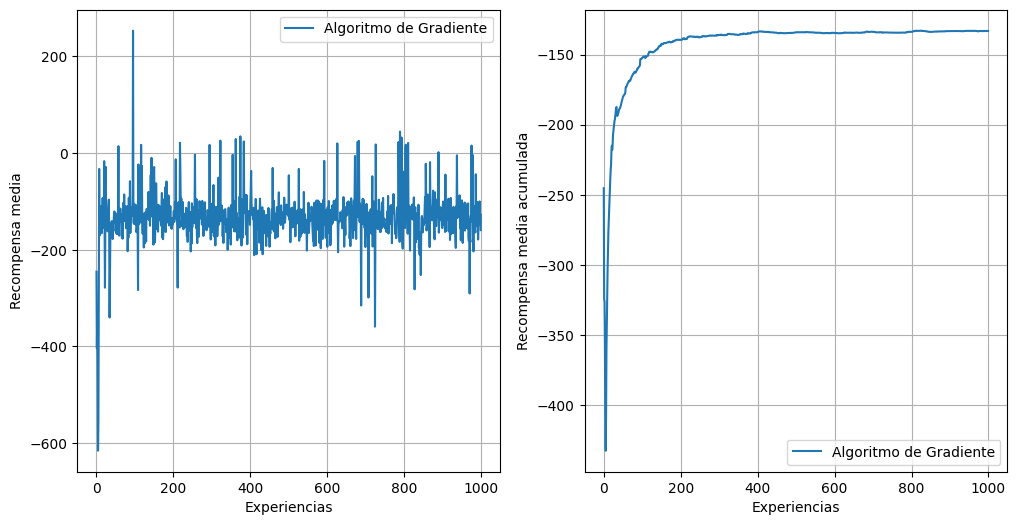

[12.61251637 -4.82978378  1.52751986 -9.31025245]


In [57]:
model_ascenso_gradiente = ModeloAscensoGradiente('LunarLander-v2', 4)
# Parámetros de la función entrenar: (episodios, ratio aprendizaje)
model_ascenso_gradiente.entrenar(1000, 0.1, 10)
print(model_ascenso_gradiente.preferencias)

**Glosario.**
- Episodios:
Los episodios se refieren a una secuencia completa de pasos desde el inicio hasta el final de una tarea en un entorno de aprendizaje por refuerzo. Cada episodio comienza en un estado inicial y avanza a través de una serie de estados y acciones hasta alcanzar un estado terminal (final), donde se reinicia el proceso. La duración de un episodio puede variar dependiendo del entorno y de las decisiones del agente.
- Ratio de Aprendizaje (Learning Rate):
El ratio de aprendizaje, también conocido como tasa de aprendizaje, es un parámetro que determina la magnitud de los ajustes realizados en los valores de los parámetros del modelo durante el proceso de entrenamiento. En el contexto del aprendizaje por refuerzo, afecta cómo de rápido o lento se actualizan los valores de la función de valor o de la política después de cada interacción con el entorno. Un ratio de aprendizaje alto puede hacer que el modelo aprenda rápidamente, pero también puede llevar a oscilaciones inestables, mientras que un ratio bajo proporciona un aprendizaje más estable pero más lento.
- Probabilidad de Exploración (Exploration Probability):
La probabilidad de exploración es un valor que controla la frecuencia con la que un agente elige realizar una acción aleatoria en lugar de seguir su política actual durante el entrenamiento. Esta estrategia, conocida como epsilon-greedy, equilibra la exploración de nuevas acciones y la explotación de las acciones conocidas para maximizar la recompensa. Al principio del entrenamiento, se suele usar una alta probabilidad de exploración para descubrir el espacio de acción, que se reduce gradualmente para explotar las mejores acciones aprendidas.
- Decaimiento Epsilon (Epsilon Decay):
El decaimiento epsilon es una técnica utilizada para reducir gradualmente la probabilidad de exploración (epsilon) a lo largo del tiempo durante el entrenamiento del agente. Inicialmente, epsilon tiene un valor alto para promover la exploración, pero disminuye progresivamente a medida que el agente aprende más sobre el entorno y puede tomar decisiones más informadas. Esto permite que el agente explote más las acciones que proporcionan mayor recompensa a medida que mejora su política.
- Factor de Descuento (Discount Factor):
El factor de descuento es un parámetro que cuantifica la importancia de las recompensas futuras en el cálculo del valor actual de una política. En el aprendizaje por refuerzo, las recompensas recibidas en el futuro se multiplican por el factor de descuento para determinar su valor presente. Un factor de descuento cercano a 1 implica que se valoran casi igual las recompensas futuras y presentes, mientras que un valor cercano a 0 hace que el agente se enfoque principalmente en las recompensas inmediatas. El factor de descuento permite equilibrar entre maximizar recompensas a corto plazo y a largo plazo.
- Valor Inicial:
El valor inicial se refiere al valor con el cual se inicializan todas las entradas de la tabla Q (q_tabla) al comienzo del entrenamiento.
En el modelo se utilizan valores iniciales optimistas. Esto significa que las entradas de la tabla Q se inicializan con un valor alto. Esta estrategia fomenta la exploración, ya que las acciones no exploradas previamente parecen tener un alto valor potencial, impulsando al agente a probar nuevas acciones en lugar de quedarse con las acciones que ya ha probado y que han dado resultados subóptimos.
- Tiempo:
El parámetro tiempo se refiere al número de iteraciones o pasos que el modelo ha realizado durante su entrenamiento. Se utiliza para calcular el promedio de recompensas de manera incremental. En cada paso, tiempo se incrementa en uno.
- Cantidad de Acciones:
El parámetro num_acciones indica el número de acciones posibles que el agente puede tomar en el entorno. Este número se utiliza para definir el tamaño del vector de preferencias (preferencias) y probabilidades (probabilidades), que mantienen un registro de la probabilidad de elegir cada acción y la preferencia asociada a cada acción, respectivamente.
- Preferencias:
El vector preferencias contiene los valores que indican la preferencia del agente por cada una de las acciones posibles. Estas preferencias se actualizan durante el entrenamiento basado en las recompensas recibidas.
- Softmax:
La función softmax convierte el vector de preferencias en un vector de probabilidades. Calcula la exponencial de cada preferencia (ajustada por la máxima preferencia para estabilidad numérica) y luego normaliza estos valores para obtener un conjunto de probabilidades que suman a 1.